**Imports:**

In [1]:
%reload_ext autoreload
%autoreload 1
from model_files.model import MushroomClassifier,MushroomDataModule, MushroomTuner
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import cv2
import joblib
import numpy as np
import torch
import pytorch_lightning as ptl
from PIL import Image
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import model_files.tuning as tunes
from ray import tune
from ray.tune.stopper import MaximumIterationStopper
from ray.tune.search.optuna import OptunaSearch
from ray import train
from sklearn.metrics import classification_report
%aimport model_files.tuning
%aimport model_files.model

**Download the data:**

**Unzip the data and remove redundant files:**

**Settings:**

In [2]:
BASE_FIG_SIZE=(8.5,5)
BASE_DIR = os.getcwd()

## Exploratory Data Analysis

**Setting up a data loader for the eda:**

In [3]:
eda_data_module=MushroomDataModule()
eda_data_module.setup()
eda_loader=eda_data_module.train_dataloader()

### Sample Overview

**Number of samples for each genus:**

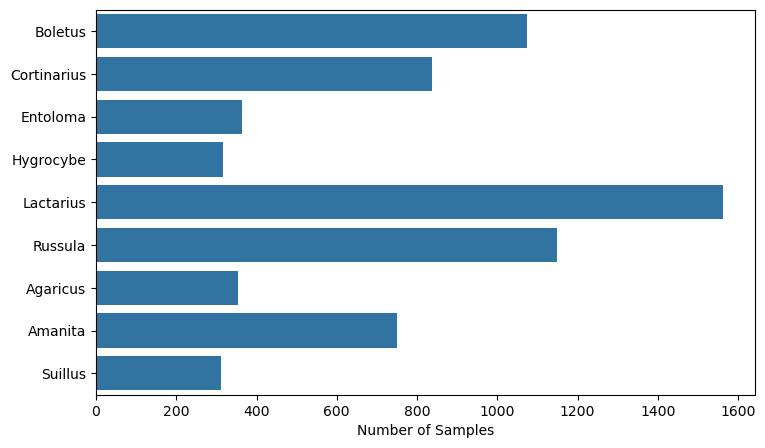

In [4]:
files=os.listdir("Mushrooms")
genuses = [file for file in files]
genus_data_count={}
for genus in genuses:
    pics=os.listdir(f"Mushrooms/{genus}")
    genus_data_count[genus]=len([pic for pic in pics])
genus_data_count
fig_data_count,ax_data_count=plt.subplots(figsize=BASE_FIG_SIZE)
sns.barplot(genus_data_count,orient='y',ax=ax_data_count)
ax_data_count.set_xlabel("Number of Samples")
plt.show()

**A visual representation of a sample from each class:**

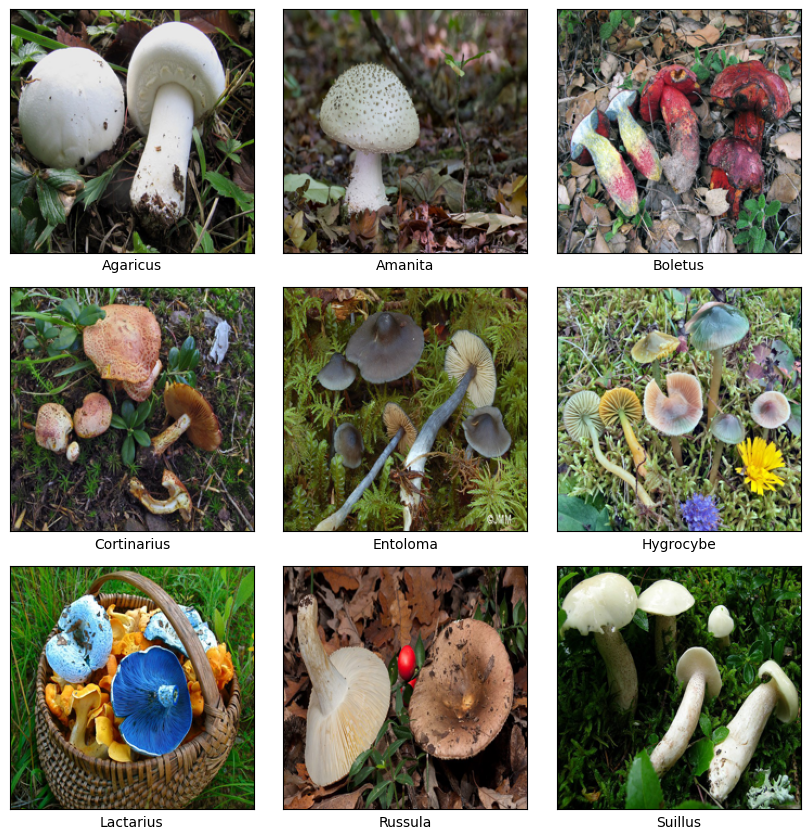

In [5]:
images=pl.DataFrame(eda_loader.dataset.dataset.samples,schema=['path','class'])
class_dict={item:key for key, item in eda_loader.dataset.dataset.class_to_idx.items()}
fig_sample,ax_sample=plt.subplots(3,3,figsize=(BASE_FIG_SIZE[0],BASE_FIG_SIZE[0]))
ax_sample=ax_sample.flatten()
for i in range(9):
    path=images.filter(pl.col("class")==i).sample(1)["path"].item()
    image = Image.open(path)
    image = image.resize((225, 225))
    ax_sample[i].imshow(image)
    ax_sample[i].set_xlabel(class_dict[i])
    ax_sample[i].set_xticks([])
    ax_sample[i].set_yticks([])
plt.tight_layout(w_pad=0.1)

### Image Dimensions

**Getting image dimensions:**

In [6]:
sizes = {}
for genus in genus_data_count.keys():
    sizes[genus] = pl.DataFrame(schema={"name":str, "height":int, "width":int, "channels":int})
    for img_name in os.listdir(f"Mushrooms/{genus}"):
        img = cv2.imread(f"Mushrooms/{genus}/{img_name}")
        height, width, channels = img.shape
        extend_df = pl.DataFrame(
            {"name": img_name, "height": height, "width": width, "channels": channels}
        )
        sizes[genus]=sizes[genus].extend(extend_df)

Premature end of JPEG file


**Image dimension distribution by genus:**

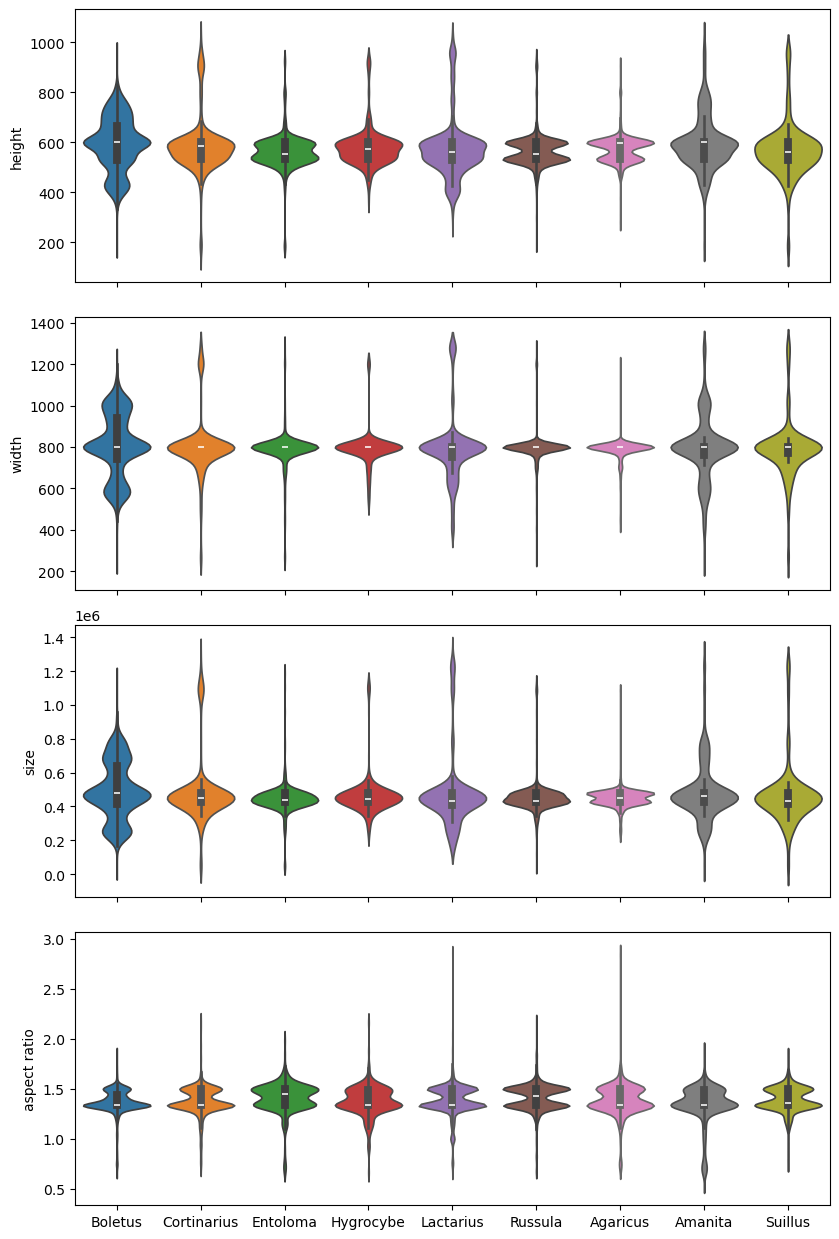

In [7]:
fig_sizes, ax_sizes = plt.subplots(
    4, 1, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 2.5), sharex=True
)
for i, genus in enumerate(sizes.keys()):
    sns.violinplot(y=sizes[genus]["height"], x=i, ax=ax_sizes[0])
    sns.violinplot(y=sizes[genus]["width"], x=i, ax=ax_sizes[1])
    sns.violinplot(
        y=sizes[genus]
        .select((pl.col("height") * pl.col("width")).alias("size"))
        .to_series(),
        x=i,
        ax=ax_sizes[2],
    )
    sns.violinplot(
        y=sizes[genus]
        .select((pl.col("width") / pl.col("height")).alias("aspect ratio"))
        .to_series(),
        x=i,
        ax=ax_sizes[3],
    )

ax_sizes[3].set_xticks(ticks=np.arange(len(sizes)), labels=sizes.keys())
plt.tight_layout()
plt.show()

## Model Setup and Option Trials:

**Setting up a logger for tensorbord:**

In [8]:
tb_logger = ptl.loggers.TensorBoardLogger('logs')

**Setting up early stopping**

In [9]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    min_delta=0.001,
)

Model training will stop if the loss has not improved from epoch to epoch more than 0.001, yet no earlier than 5 epochs.

**Setting up a trainable for option/hyper-parameter tuning with rat-tune:**

In [10]:
early_stopping_config = {
    "monitor": "val_loss",
    "patience": 5,
    "mode": "min",
    "min_delta": 0.001,
}
fine_tuning_config = {
    "unfreeze_at_epoch": tune.randint(5, 11),
    "tuning_lr": tune.loguniform(1e-7, 1e-3),
}

In [11]:
stopper = MaximumIterationStopper(1)
tuner = tune.Tuner(
    trainable=tune.with_resources(
        tune.with_parameters(
            tunes.TrainableP2L,
            model=MushroomClassifier,
            dm=MushroomDataModule,
            metric="val_loss",
            logger=tb_logger,
        ),
        resources={"CPU": 2, "GPU": 1},
    ),
    run_config=train.RunConfig(
        stop=stopper,
        storage_path=f"{BASE_DIR}/logs/ray/",
        name="tunning",
        checkpoint_config=train.CheckpointConfig(
            checkpoint_at_end=False,
        ),
    ),
    tune_config=tune.TuneConfig(
        search_alg=OptunaSearch(),
        mode="min",
        metric="score",
        num_samples=50,
    ),
    param_space={
        "batch_size": tune.randint(32, 128),
        "img_size": 224,
        "max_epochs": 22,
        "learning_rate": tune.loguniform(0.00001, 0.01),
        "num_classes": 9,
        "architecture": tune.choice(["resnet18","squeezenet","google"]),
        "optimizer": tune.choice(["adam","sgd"]),
        "l2":tune.loguniform(1e-6,1),
        "early_stopping_params":early_stopping_config,
        "fine_tuning_params":fine_tuning_config,
        "base_dir":BASE_DIR
    },
)

In this single step the best architecture, optimizer, preprocessing and model options are selected. The tuning is performed using ray-tune class API, on a single GPU. 50 trials are run and the best one is selected by the lowest loss (cross entropy). In this stage the options are as follows:

1. Preprocessing:
    * Batch Size 32-128
2. Optimizers:
    * Optimizer: either Adam or Stochastic gradient descent
    * l2 penalty: $1e^{-6}$ to $1$
3. Architectures:
    * ResNet18/SqueezeNet/GoogLeNet
4. Model Parameters:
    * Learning Rate: $1e^{-6}$ to $1e^{-2}$

**Running the option selection procedure:**

**Load results:**

In [12]:
best_params=joblib.load("temp/best_params.joblib")
best_params

{'batch_size': 78,
 'img_size': 224,
 'max_epochs': 31,
 'learning_rate': 0.00019766984899815166,
 'num_classes': 9,
 'architecture': 'resnet18',
 'optimizer': 'adam',
 'l2': 2.538433533212881e-06}

**View results in tensorboard:**

In [15]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


## Model Evaluation

**Initiating model and data module instances with the best parameters:**

In [14]:
best_params['early_stopping_params']=early_stopping_config
best_params['fine_tuning_params']={
    "unfreeze_at_epoch": 2,
    "tuning_lr": 1e-6,
}

In [15]:
best_params['base_dir']=BASE_DIR

In [16]:
trainer, best_model, best_dm = tunes.config_trainer_model_dm(
    best_params,
    MushroomClassifier,
    MushroomDataModule,
    tb_logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


**Fitting the model:**

In [17]:
trainer.fit(best_model,best_dm)

2023-12-13 16:40:41.394328: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-13 16:40:41.395800: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-13 16:40:41.415372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 16:40:41.415395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 16:40:41.415966: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/gediminas/anaconda3/envs/DL/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/gediminas/anaconda3/envs/DL/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


The model was fully trained in 11 epochs, when it was stopped due to no further improvement.

**Testing the model:**

In [19]:
trainer.test(best_model,best_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


frozen


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.7773641347885132
        test_loss           0.7298914194107056
 test_weighted_f1_score     0.7797688841819763
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7298914194107056,
  'test_accuracy': 0.7773641347885132,
  'test_weighted_f1_score': 0.7797688841819763}]

**Loading test data:**

In [ ]:
best_dm.setup()
test_loader=best_dm.test_dataloader()

**Making prediction on the test set:**

In [ ]:
predictions=trainer.predict(best_model,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

**Moving the predictions and true classes into a data frame:**

In [ ]:
predictions_all = torch.cat(predictions, dim=0)
predictions_rounded = torch.argmax(predictions_all, dim=1)
predictions_rounded = pl.DataFrame(predictions_rounded.numpy(), schema=["prediction"])
predictions_rounded = predictions_rounded.with_columns(
    pl.DataFrame(
        [test_loader.dataset.dataset.samples[i] for i in test_loader.dataset.indices]
    )[:, 1].alias("true")
)

**Classification report:**

In [ ]:
print(classification_report(predictions_rounded['true'],predictions_rounded['prediction']))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83        71
           1       0.87      0.87      0.87       150
           2       0.88      0.97      0.92       215
           3       0.81      0.77      0.79       167
           4       0.86      0.77      0.81        73
           5       0.93      0.86      0.89        63
           6       0.85      0.90      0.87       313
           7       0.86      0.83      0.85       229
           8       0.71      0.55      0.62        62

    accuracy                           0.85      1343
   macro avg       0.84      0.82      0.83      1343
weighted avg       0.85      0.85      0.85      1343

